In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from collections import Counter
from model import MarginLoss, make_model
from torch.optim import lr_scheduler
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [2]:
# Define the transfer learning dataset
data_path = 'numbers'

transfer_target_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Pad(2),
        transforms.RandomCrop((28, 28)),
        transforms.ToTensor(),
]))

class_mapping = transfer_target_dataset.class_to_idx
class_mapping

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8}

In [3]:
# Split data to test and train
# Use 80% to train
train_size = int(0.8 * len(transfer_target_dataset))
test_size = len(transfer_target_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(transfer_target_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print('Train size: ', len(train_dataset))
print('Test size: ', len(test_dataset))

Train size:  1292
Test size:  323


In [4]:
# Label distribution
train_classes = [label for _, label in transfer_target_dataset]
Counter(train_classes)

Counter({0: 188,
         1: 185,
         2: 190,
         3: 168,
         4: 166,
         5: 175,
         6: 165,
         7: 191,
         8: 187})

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

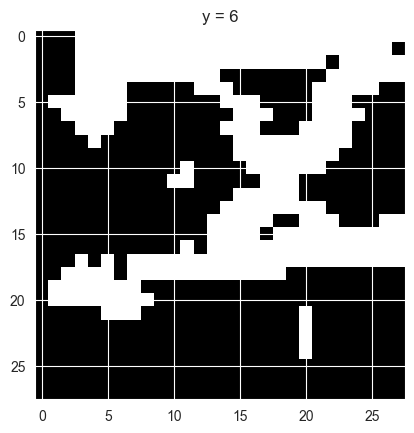

In [6]:
# Check a sample
sample = next(iter(train_loader))

plt.imshow(sample[0][0].reshape(28, 28), cmap='gray')
plt.title('y = {}'.format(sample[1][0]))
plt.show()

In [7]:
model = make_model()
model.load_state_dict(torch.load('checkpoints/019_model_dict_reconstructionTrue.pth')['model_state_dict'])

model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

EfficientCapsNetWithReconstruction(
  (efficient_capsnet): EfficientCapsNet(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
    (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (primary_caps): PrimaryCapsLayer(
      (depthwise_conv): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=128)
    )
    (digit_caps): RoutingLayer()
  )
  (reconstruction_net): Recons

In [8]:
args = {
    "batch_size": 64,
    "test_batch_size": 64,
    "epochs": 50,
    "lr": 5e-4,
    "reconstruction_alpha": 0.0005,
}

optimizer = optim.Adam(model.parameters(), lr=args["lr"])

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, verbose=True, factor=0.9, patience=4, min_lr=1e-5, mode="max"
)

loss_fn = MarginLoss(0.9, 0.1, 0.5)

In [9]:
confusion_mat = np.zeros((9, 9), dtype=int)
max_test_accuracy = 0

def train(current_epoch):
    model.train()
    # 將train_loader包裝在tqdm進度條中
    train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Train Epoch: {current_epoch}')
    for batch_idx, (data, target) in train_loader_tqdm:
        data, target = data.to(device), target.to(device)
        
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        
        output, probs = model(data)
        reconstruction_loss = F.mse_loss(output, data.view(-1, 784))
        margin_loss = loss_fn(probs, target)
        loss = args["reconstruction_alpha"] * reconstruction_loss + margin_loss
            
        loss.backward()
        optimizer.step()
        
        # 更新tqdm進度條的描述信息
        train_loader_tqdm.set_description(
            "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                current_epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100.0 * batch_idx / len(train_loader),
                loss.item(),
            )
        )
            
def test(final=False):
    global confusion_mat, max_test_accuracy
    model.eval()
    test_loss = 0
    correct = 0
    if final:
        confusion_mat = np.zeros((9, 9), dtype=int)
    with tqdm(test_loader, unit="batch", desc="Test Set") as test_loader_tqdm:
        for data, target in test_loader_tqdm:
            data, target = data.to(device), target.to(device)
            data, target = Variable(data), Variable(target)

            output, probs = model(data)
            reconstruction_loss = F.mse_loss(
                output, data.view(-1, 784), reduction='sum'
            ).item()
            test_loss += loss_fn(probs, target, size_average=False).item()
            test_loss += args["reconstruction_alpha"] * reconstruction_loss

            pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            if final:
                for i in range(len(pred)):
                    true_label = target.data[i]
                    pred_label = pred.data[i]
                    confusion_mat[true_label][pred_label] += 1
            test_loader_tqdm.set_postfix(Loss=test_loss / len(test_loader.dataset), Accuracy=100.0 * correct / len(test_loader.dataset))
            
            if 100.0 * correct / len(test_loader.dataset) > max_test_accuracy:
                max_test_accuracy = 100.0 * correct / len(test_loader.dataset)
                torch.save(
                    model.state_dict(),
                    f"checkpoints/{max_test_accuracy:0.2f}_reconstruction_transfer.pth",
                )

    if final:
        sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title("Efficient CapsNet - MNIST Confusion Matrix")
        plt.savefig("confusion_mat-reconstruction.png")
    return test_loss

Test Set: 100%|██████████| 6/6 [00:00<00:00, 39.19batch/s, Accuracy=tensor(89.7833), Loss=0.183]


Epoch 00006: reducing learning rate of group 0 to 4.5000e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 48.00batch/s, Accuracy=tensor(94.1176), Loss=0.139]


Epoch 00011: reducing learning rate of group 0 to 4.0500e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 44.48batch/s, Accuracy=tensor(97.2136), Loss=0.113]


Epoch 00016: reducing learning rate of group 0 to 3.6450e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 51.28batch/s, Accuracy=tensor(97.2136), Loss=0.107]


Epoch 00021: reducing learning rate of group 0 to 3.2805e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 48.39batch/s, Accuracy=tensor(96.2848), Loss=0.101]


Epoch 00026: reducing learning rate of group 0 to 2.9525e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 47.53batch/s, Accuracy=tensor(96.5944), Loss=0.107]


Epoch 00031: reducing learning rate of group 0 to 2.6572e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 48.00batch/s, Accuracy=tensor(98.1424), Loss=0.101]


Epoch 00036: reducing learning rate of group 0 to 2.3915e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 48.74batch/s, Accuracy=tensor(97.5232), Loss=0.107]


Epoch 00041: reducing learning rate of group 0 to 2.1523e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 49.18batch/s, Accuracy=tensor(97.8328), Loss=0.103]


Epoch 00046: reducing learning rate of group 0 to 1.9371e-04.


Test Set: 100%|██████████| 6/6 [00:00<00:00, 35.28batch/s, Accuracy=tensor(98.1424), Loss=0.0958]



 ---------------------------- Finished Training ---------------------------- 


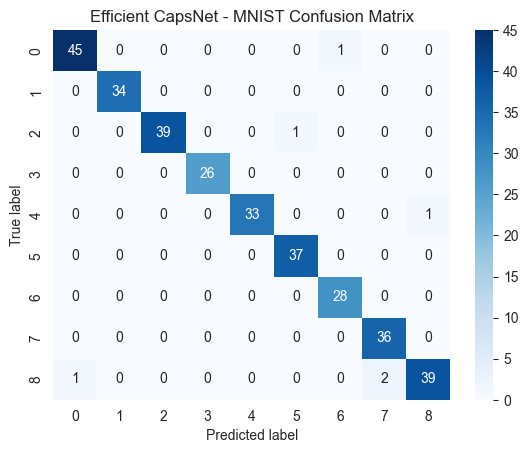

In [10]:
for epoch in range(1, args["epochs"] + 1):
    final = True if epoch == args["epochs"] else False
    train(epoch)
    test_loss = test(final)
    scheduler.step(test_loss)
    if epoch % 10 == 0 or epoch == args["epochs"]:
        # Save the model dict
        torch.save(
            model.state_dict(),
            f"checkpoints/{epoch:03d}_model_dict_reconstruction_transfer.pth",
        )

print("\n", "-" * 28, "Finished Training", "-" * 28, "\n")